## Train pointwise ML model using first order gradients, use wider stencil

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

Working at scale:50
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Loaded from saved norm nc
Normalized data
loading
stacking, droping nans, randomizing
Test and train batches split. Number of batches: 56-5
Train loss step 0:  0.45840159324663027 test loss: 0.21161480545997619
Train loss step 20:  0.034871282787727456 test loss: 0.037348415702581406
Train loss step 40:  0.03307381701389594 test loss: 0.03632868453860283
Train loss step 60:  0.03246498127867069 test loss: 0.035947945713996884
Train loss step 80:  0.03220043374624636 test loss: 0.03581160306930542
Train loss step 100:  0.032069454135905416 test loss: 0.0356017105281353
Train loss step 120:  0.031971233863649626 test loss: 0.03554617911577225
Train loss step 140:  0.031894272625712414 test loss: 0.0353912316262722
Train loss step 160:  0.031803789282483716 test loss: 0.0350514329969883
Train loss step 180:  0.03173280191341681 test loss: 0.034946434944868085
Train los

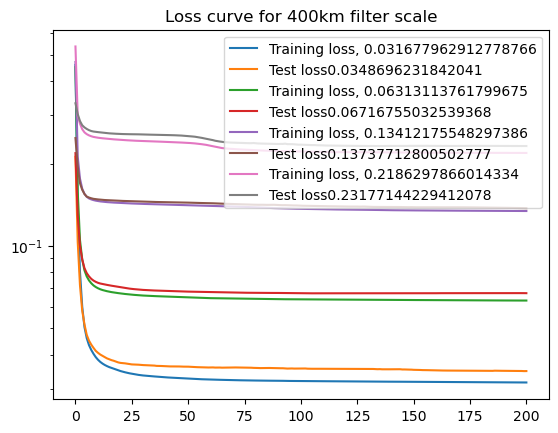

In [5]:
kind = 'MITgcm'
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

Lkeys  = ['50', '100', '200', '400']

for L in Lkeys: 
    print('Working at scale:' + L)
    Lint = int(L)
    fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'
    
    # Open dataset
    ML_data = datasets.MITgcm_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
    ML_data.convert_subsampled_normed();
    ML_data.generate_test_train_batches();
    
    # Setup ML model
    ANN_model   = ML_classes.ANN(num_in = len(ML_data.input_channels))
    regress_sys = ML_classes.RegressionSystem(ANN_model)
    
    regress_sys.train_system(ML_data, 201)
    
    ## Loss plot
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.title('Loss curve for '+ L+ 'km filter scale')
    plt.grid()
    plt.yscale('log')
    plt.legend()
    
    # Save the checkpoint
    CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_'+L+'_MITgcm'#+'_'+str(bias)
    regress_sys.save_checkpoint(CKPT_DIR)
    
    # Save model nc file
    model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MITgcm_'+L+'.nc'
    regress_sys.save_weights_nc(model_nc)
    
plt.savefig('figures/MITgcm_single_all_km_loss_curve.png')